# Lab: Decision Trees
## Fitting Classification Trees

The `tree` library is used to construct classification and regression trees.

In [1]:
#install.packages('tree')

In [2]:
library(tree)

We first use classification trees  to analyze the `Carseats` data set.
In these data, `Sales` is a continuous variable, and so we begin by recoding it  as a binary variable. We use the `ifelse()` function to create a variable, called `High`, which takes on a value of `Yes` if the `Sales` variable exceeds $8$,
and takes on a value of `No` otherwise.

In [3]:
library(ISLR2)
attach(Carseats)
High <- factor(ifelse(Sales <= 8, "No", "Yes"))

Finally, we use the `data.frame()` function to merge `High` with the rest of the `Carseats` data.

In [4]:
Carseats <- data.frame(Carseats, High)

We now  use the `tree()` function to fit a classification tree in order to predict `High` using all variables but `Sales`.
The syntax of the `tree()` function is quite similar to that of the `lm()` function.

In [5]:
tree.carseats <- tree(High ~ . - Sales, Carseats)

The `summary()` function lists the variables that are used as internal nodes in the tree, the number of terminal nodes, and the (training) error rate.

In [6]:
summary(tree.carseats)


Classification tree:
tree(formula = High ~ . - Sales, data = Carseats)
Variables actually used in tree construction:
[1] "ShelveLoc"   "Price"       "Income"      "CompPrice"   "Population" 
[6] "Advertising" "Age"         "US"         
Number of terminal nodes:  27 
Residual mean deviance:  0.4575 = 170.7 / 373 
Misclassification error rate: 0.09 = 36 / 400 

We see that the training error rate is  $9\%$.
For classification trees, the deviance reported in the output of `summary()` is
given by
\[
-2 \sum_m \sum_k n_{mk} \log \hat{p}_{mk},
\]
 where $n_{mk}$ is the number of observations in the $m$th terminal node that belong to the $k$th class. This is closely related to the entropy, defined in (8.7).
A small deviance indicates a tree that provides a good fit to the (training) data.
The *residual mean deviance* reported is simply the deviance divided by $n-|{T}_0|$, which in this case is $400-27=373$.

One of the most attractive properties of trees is that they can be  graphically displayed. We use the `plot()` function to display the tree structure, and the `text()` function to display the node labels. The argument `pretty = 0` instructs `R` to include the category names for any qualitative predictors, rather than simply displaying a letter for each category.

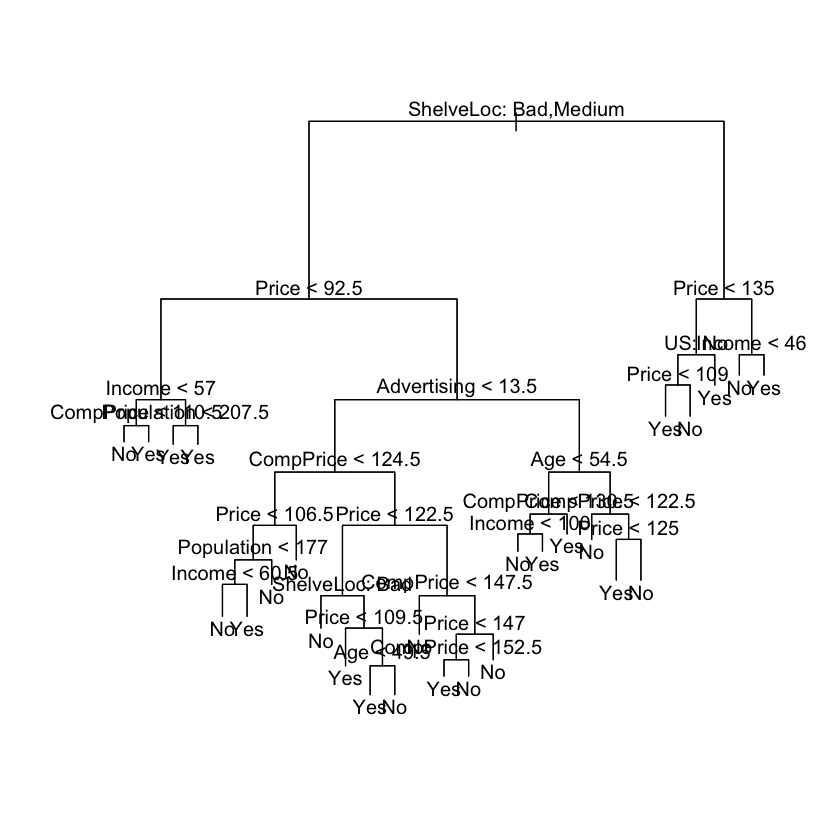

In [7]:
plot(tree.carseats)
text(tree.carseats, pretty = 0)

The most important indicator of `Sales` appears to be shelving location, since the first branch differentiates `Good` locations from `Bad` and `Medium` locations.

If we just type the name of the tree object,  `R` prints output corresponding to each branch of the tree. `R` displays the split criterion  (e.g. `Price < 92.5`), the number of observations in  that branch, the deviance,  the overall prediction for the branch (`Yes` or `No`),  and the fraction of observations in that branch that take on values of `Yes` and `No`. Branches that lead to terminal nodes are indicated using asterisks.

In [8]:
tree.carseats

node), split, n, deviance, yval, (yprob)
      * denotes terminal node

  1) root 400 541.500 No ( 0.59000 0.41000 )  
    2) ShelveLoc: Bad,Medium 315 390.600 No ( 0.68889 0.31111 )  
      4) Price < 92.5 46  56.530 Yes ( 0.30435 0.69565 )  
        8) Income < 57 10  12.220 No ( 0.70000 0.30000 )  
         16) CompPrice < 110.5 5   0.000 No ( 1.00000 0.00000 ) *
         17) CompPrice > 110.5 5   6.730 Yes ( 0.40000 0.60000 ) *
        9) Income > 57 36  35.470 Yes ( 0.19444 0.80556 )  
         18) Population < 207.5 16  21.170 Yes ( 0.37500 0.62500 ) *
         19) Population > 207.5 20   7.941 Yes ( 0.05000 0.95000 ) *
      5) Price > 92.5 269 299.800 No ( 0.75465 0.24535 )  
       10) Advertising < 13.5 224 213.200 No ( 0.81696 0.18304 )  
         20) CompPrice < 124.5 96  44.890 No ( 0.93750 0.06250 )  
           40) Price < 106.5 38  33.150 No ( 0.84211 0.15789 )  
             80) Population < 177 12  16.300 No ( 0.58333 0.41667 )  
              160) Income < 60.5 6   0

In order to properly evaluate the performance of a classification tree
on these data, we must estimate the test error rather than simply
computing the training error. We split the observations into a
training set and a test set, build the tree using the training set,
and evaluate its performance on the test data. The `predict()`
function can be used for this purpose. In the case of a classification
tree, the argument `type = "class"` instructs `R` to return the
actual class prediction. This approach leads to correct predictions
for around $77\,\%$ of the locations in the test data set.

In [9]:
set.seed(2)
train <- sample(1:nrow(Carseats), 200)
Carseats.test <- Carseats[-train, ]
High.test <- High[-train]
tree.carseats <- tree(High ~ . - Sales, Carseats,
    subset = train)
tree.pred <- predict(tree.carseats, Carseats.test,
    type = "class")
table(tree.pred, High.test)
(104 + 50) / 200

         High.test
tree.pred  No Yes
      No  104  33
      Yes  13  50

[1] 0.77

(If you re-run the `predict()` function then you might get slightly different results, due to "ties": for instance, this can happen when the training observations corresponding to a terminal node are evenly split between `Yes` and `No` response values.)

Next, we consider whether pruning the tree might lead to improved  results.
The function `cv.tree()` performs cross-validation in order to  determine the optimal level of tree complexity; cost complexity pruning is used in order to select a sequence of trees for consideration.
We use the argument `FUN = prune.misclass` in order to indicate that we want the classification error rate to guide the cross-validation and pruning process, rather than the default for the `cv.tree()` function, which is deviance. The `cv.tree()` function reports the number of terminal nodes of each tree considered (`size`) as well as the corresponding error rate and the value of the cost-complexity parameter used (`k`, which corresponds to $\alpha$ in (8.4)).

In [10]:
set.seed(7)
cv.carseats <- cv.tree(tree.carseats, FUN = prune.misclass)
names(cv.carseats)
cv.carseats

[1] "size"   "dev"    "k"      "method"

$size
[1] 21 19 14  9  8  5  3  2  1

$dev
[1] 75 75 75 74 82 83 83 85 82

$k
[1] -Inf  0.0  1.0  1.4  2.0  3.0  4.0  9.0 18.0

$method
[1] "misclass"

attr(,"class")
[1] "prune"         "tree.sequence"

Despite its name, `dev` corresponds to the number of
cross-validation errors. The tree with 9 terminal nodes results in only 74 cross-validation errors.  We plot
the  error rate as a function of both `size` and
`k`.

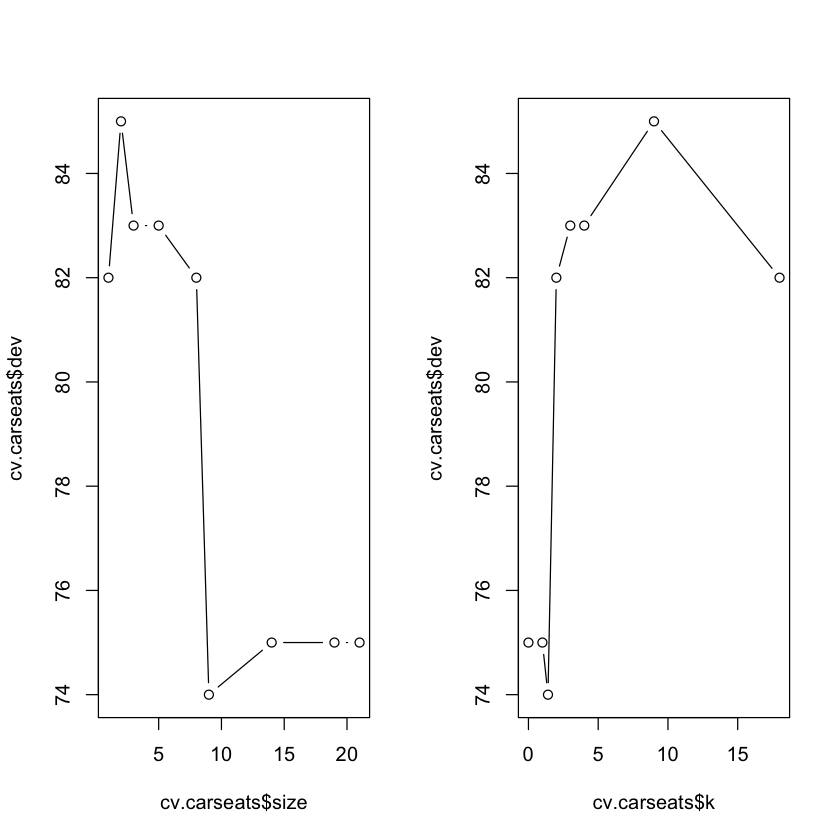

In [11]:
par(mfrow = c(1, 2))
plot(cv.carseats$size, cv.carseats$dev, type = "b")
plot(cv.carseats$k, cv.carseats$dev, type = "b")

We now apply the  `prune.misclass()`  function in order to prune the tree to obtain the nine-node tree.

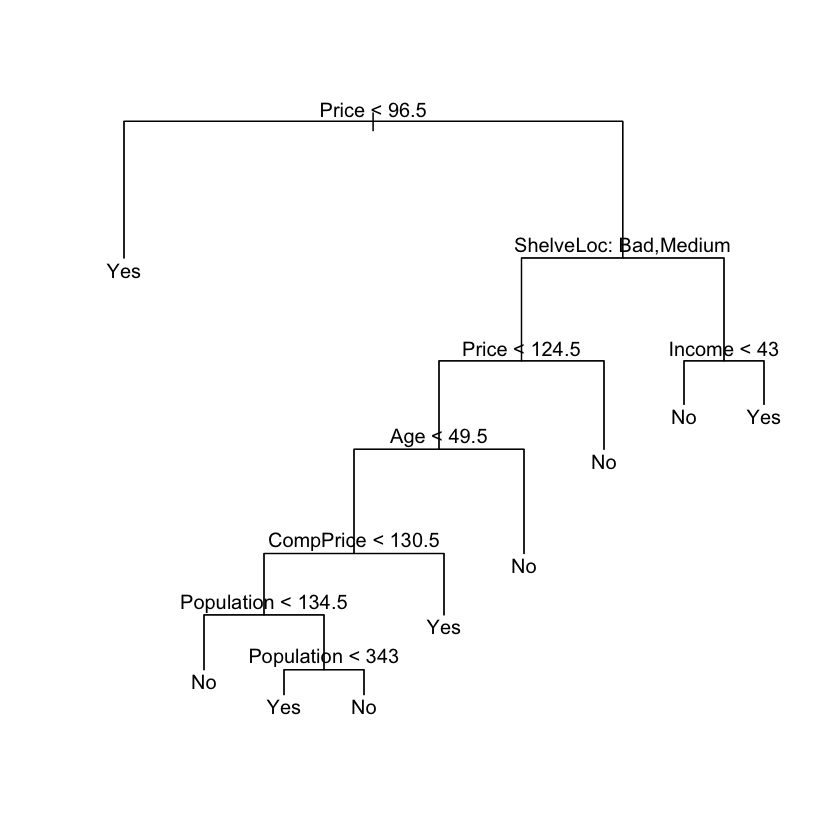

In [12]:
prune.carseats <- prune.misclass(tree.carseats, best = 9)
plot(prune.carseats)
text(prune.carseats, pretty = 0)

How well does this pruned tree perform on the test data set? Once again, we apply the `predict()` function.

In [13]:
tree.pred <- predict(prune.carseats, Carseats.test,
    type = "class")
table(tree.pred, High.test)
(97 + 58) / 200

         High.test
tree.pred No Yes
      No  97  25
      Yes 20  58

[1] 0.775

Now $77.5\,\%$ of the test observations are correctly classified, so not only has the pruning process produced a more interpretable tree, but it has also slightly improved the classification accuracy.

If we increase the value of `best`, we obtain a larger pruned tree with lower classification accuracy:

         High.test
tree.pred  No Yes
      No  102  31
      Yes  15  52

[1] 0.77

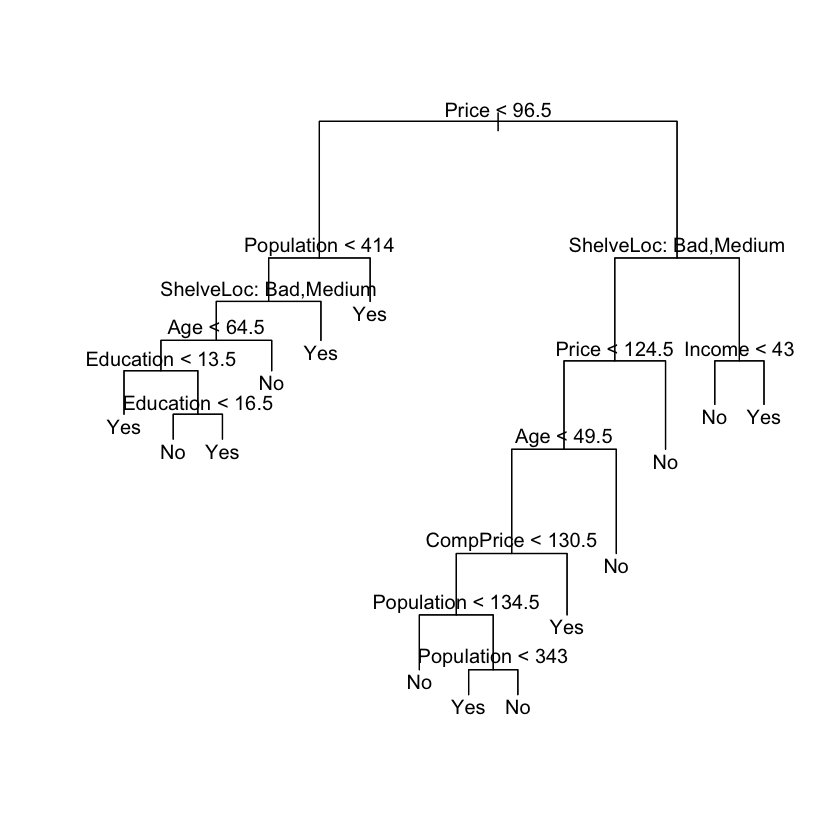

In [14]:
prune.carseats <- prune.misclass(tree.carseats, best = 14)
plot(prune.carseats)
text(prune.carseats, pretty = 0)
tree.pred <- predict(prune.carseats, Carseats.test,
    type = "class")
table(tree.pred, High.test)
(102 + 52) / 200

## Fitting Regression Trees

Here we fit a regression tree to the `Boston`  data set. First, we create a training set, and fit the tree to the training data.

In [15]:
set.seed(1)
train <- sample(1:nrow(Boston), nrow(Boston) / 2)
tree.boston <- tree(medv ~ ., Boston, subset = train)
summary(tree.boston)


Regression tree:
tree(formula = medv ~ ., data = Boston, subset = train)
Variables actually used in tree construction:
[1] "rm"    "lstat" "crim"  "age"  
Number of terminal nodes:  7 
Residual mean deviance:  10.38 = 2555 / 246 
Distribution of residuals:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-10.1800  -1.7770  -0.1775   0.0000   1.9230  16.5800 

Notice that the output of `summary()` indicates that only four of the variables have been used in constructing the tree. In the context of a regression tree, the deviance is simply the sum of squared errors for the tree. We now plot the tree.

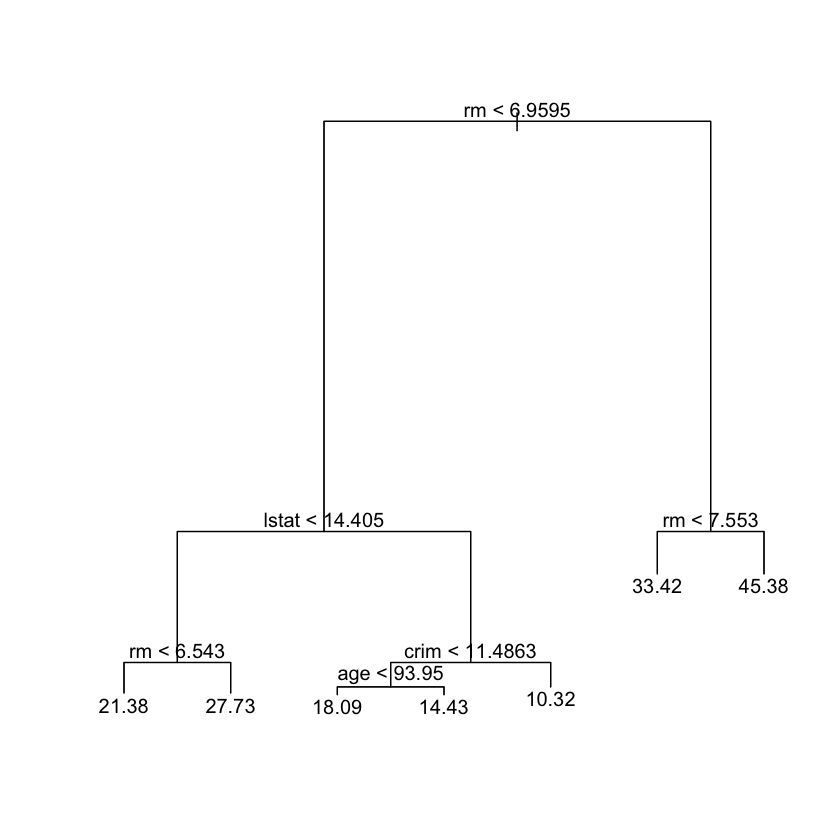

In [16]:
plot(tree.boston)
text(tree.boston, pretty = 0)

The variable `lstat` measures the percentage of individuals with {lower  socioeconomic status}, while the variable `rm` corresponds to the average number of rooms. The tree indicates that larger values of `rm`, or lower values of `lstat`, correspond to more expensive houses. For example, the tree predicts a median house price of $$45{,}400$ for homes in census tracts in which `rm >= 7.553`.

It is worth noting that we could have fit a much bigger tree, by
passing `control = tree.control(nobs = length(train), mindev = 0)` into the `tree()` function.

Now we use the `cv.tree()` function to see whether pruning the tree will improve performance.

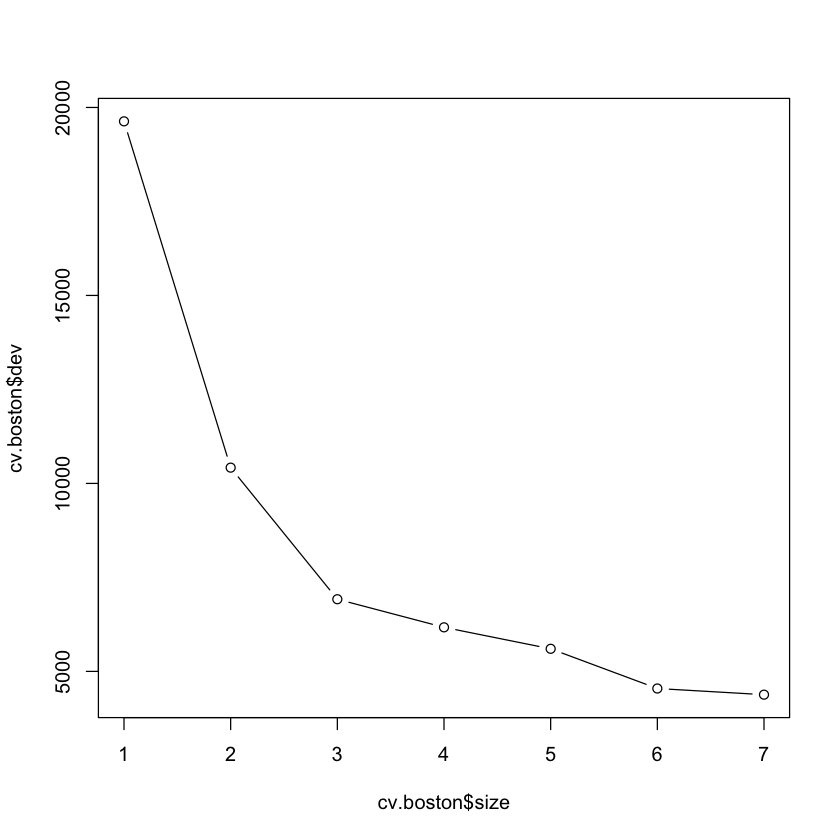

In [17]:
cv.boston <- cv.tree(tree.boston)
plot(cv.boston$size, cv.boston$dev, type = "b")

In this case, the most complex tree  under consideration is selected by cross-validation. However, if we wish to prune the tree, we could do so as follows, using the `prune.tree()` function:

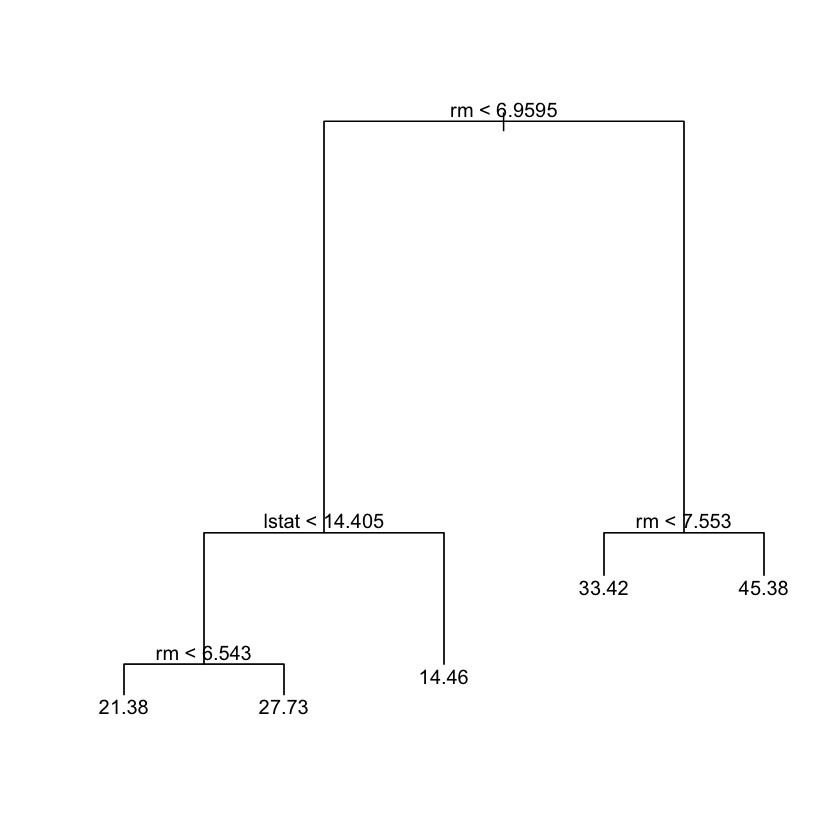

In [18]:
prune.boston <- prune.tree(tree.boston, best = 5)
plot(prune.boston)
text(prune.boston, pretty = 0)

In keeping with the cross-validation results, we use the unpruned tree to make predictions on the test set.

[1] 35.28688

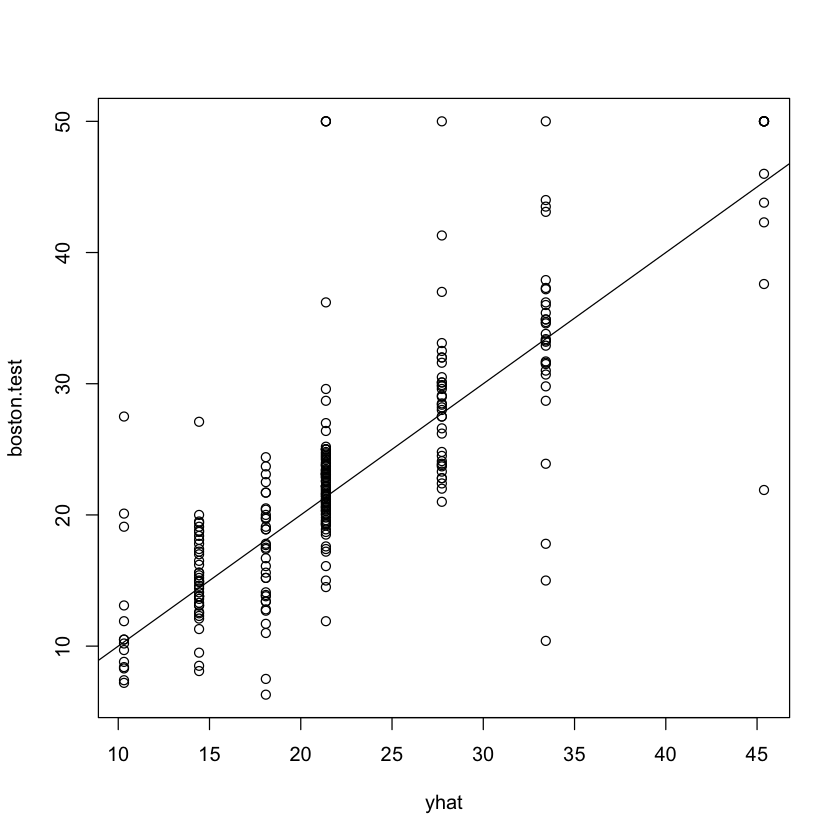

In [19]:
yhat <- predict(tree.boston, newdata = Boston[-train, ])
boston.test <- Boston[-train, "medv"]
plot(yhat, boston.test)
abline(0, 1)
mean((yhat - boston.test)^2)

In other words, the  test set MSE associated with the regression tree is $35.29$.
The square root of the MSE is therefore around $5.941$, indicating that this model leads to test predictions that are (on average) within approximately $$5{,}941$ of the true median home value for the census tract.


## Bagging and Random Forests



Here we apply bagging and random forests to the `Boston` data, using the `randomForest` package in `R`. The exact results obtained in this section may depend on the version of `R` and the version of the `randomForest` package installed on your computer.
Recall that bagging is simply a special case of a random forest with
$m=p$. Therefore, the
`randomForest()` function can be used to perform both random forests and bagging.
We perform bagging as follows:

In [22]:
#install.packages('randomForest')

In [23]:
library(randomForest)
set.seed(1)
bag.boston <- randomForest(medv ~ ., data = Boston,
    subset = train, mtry = 12, importance = TRUE)
bag.boston

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.




Call:
 randomForest(formula = medv ~ ., data = Boston, mtry = 12, importance = TRUE,      subset = train) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 12

          Mean of squared residuals: 11.40162
                    % Var explained: 85.17

The argument `mtry = 12` indicates that all $12$ predictors should be considered for each split of the tree---in other words, that bagging should be done.
How well does this bagged model perform on the test set?

[1] 23.41916

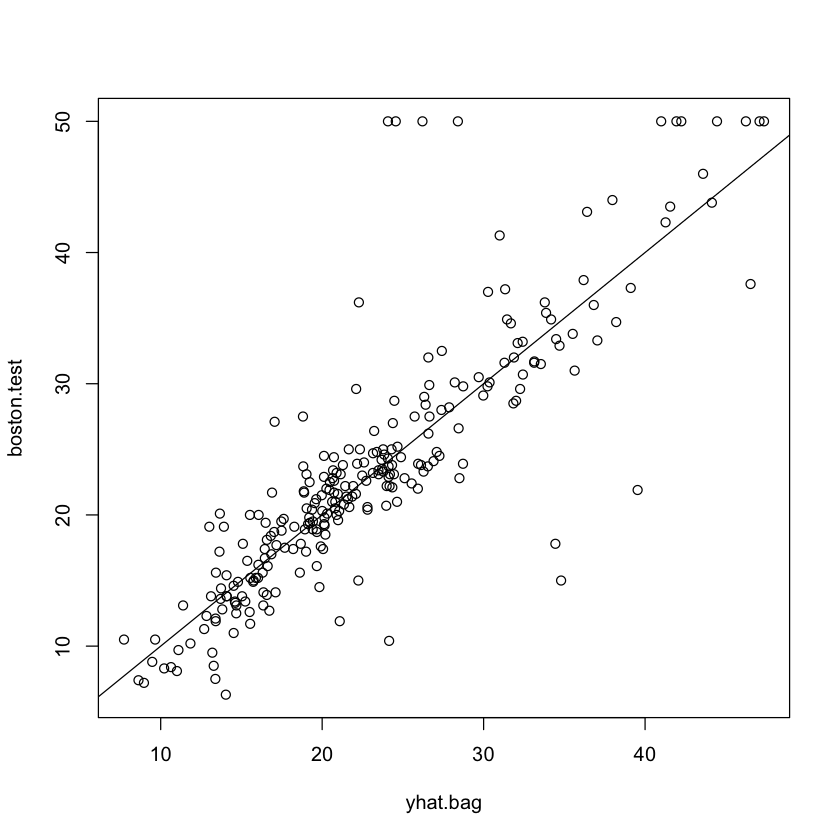

In [24]:
yhat.bag <- predict(bag.boston, newdata = Boston[-train, ])
plot(yhat.bag, boston.test)
abline(0, 1)
mean((yhat.bag - boston.test)^2)

The test set MSE associated with the bagged regression tree is $23.42$, about two-thirds of that obtained using an optimally-pruned single tree.
We could change the number of trees grown by `randomForest()` using the `ntree` argument:

In [25]:
bag.boston <- randomForest(medv ~ ., data = Boston,
    subset = train, mtry = 12, ntree = 25)
yhat.bag <- predict(bag.boston, newdata = Boston[-train, ])
mean((yhat.bag - boston.test)^2)

[1] 25.75055

Growing a random forest proceeds in exactly the same way, except that we use a smaller value of the `mtry` argument. By default, `randomForest()` uses $p/3$ variables when building a random forest of regression trees, and $\sqrt{p}$ variables when building a random forest of classification trees. Here we use `mtry = 6`.

In [26]:
set.seed(1)
rf.boston <- randomForest(medv ~ ., data = Boston,
    subset = train, mtry = 6, importance = TRUE)
yhat.rf <- predict(rf.boston, newdata = Boston[-train, ])
mean((yhat.rf - boston.test)^2)

[1] 20.06644

The test set MSE is $20.07$; this indicates that random forests yielded an improvement over bagging in this case.

Using the `importance()` function, we can view the importance of each variable.

In [27]:
importance(rf.boston)

,%IncMSE,IncNodePurity
crim,19.435587,1070.42307
zn,3.091630,82.19257
indus,6.140529,590.09536
chas,1.370310,36.70356
nox,13.263466,859.97091
rm,35.094741,8270.33906
age,15.144821,634.31220
dis,9.163776,684.87953
rad,4.793720,83.18719
tax,4.410714,292.20949


Two measures of variable importance are reported. The first is based upon the mean decrease of accuracy in predictions on the out of bag samples when a given variable is permuted. The second is a measure of the total decrease in node impurity that results from splits over that variable, averaged over all trees (this was plotted in Figure 8.9). In the case of regression trees, the node impurity is measured by the training RSS, and for classification trees by the deviance. Plots of these importance measures can be produced using the `varImpPlot()` function.

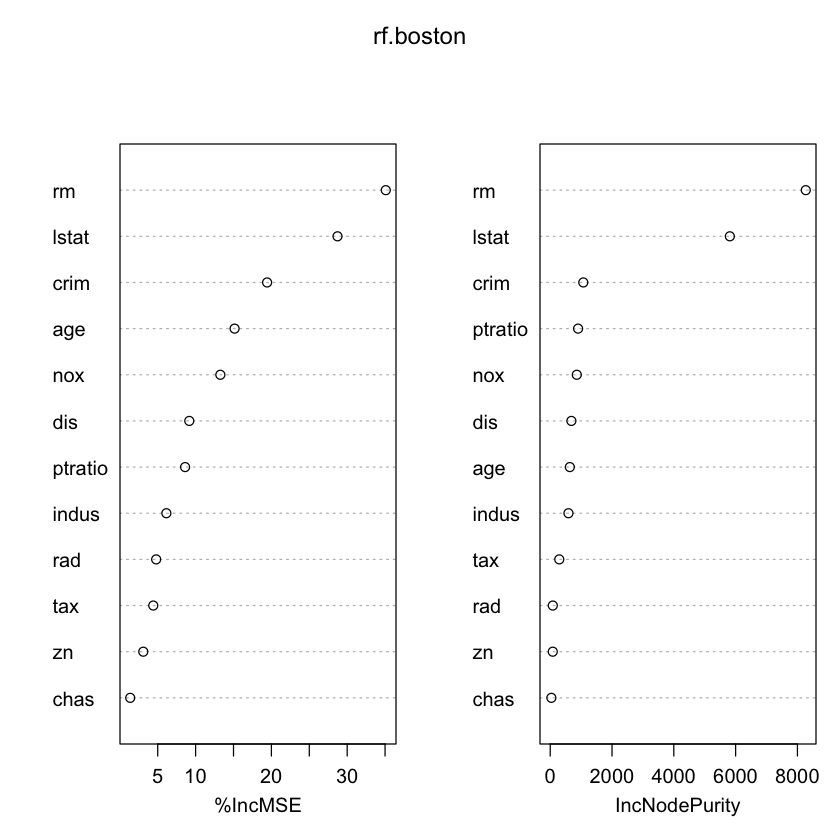

In [28]:
varImpPlot(rf.boston)

The results indicate that across all of the trees considered in the random forest, the wealth of the community (`lstat`) and the house size (`rm`) are by far the two most important variables.



## Boosting

Here we use the `gbm` package, and within it the `gbm()` function, to fit boosted regression trees to the `Boston` data set. We run `gbm()` with the option `distribution = "gaussian"` since this is a regression problem; if it were a binary classification problem, we would use `distribution = "bernoulli"`.
The argument `n.trees = 5000` indicates that we want $5000$ trees, and the option `interaction.depth = 4` limits the depth of each tree.

In [30]:
#install.packages('gbm')

In [31]:
library(gbm)
set.seed(1)
boost.boston <- gbm(medv ~ ., data = Boston[train, ],
    distribution = "gaussian", n.trees = 5000,
    interaction.depth = 4)

Loaded gbm 2.1.8.1



The `summary()` function produces a relative influence plot and also outputs the relative influence statistics.

,var,rel.inf
,<chr>,<dbl>
rm,rm,44.48249588
lstat,lstat,32.70281223
crim,crim,4.85109954
dis,dis,4.48693083
nox,nox,3.75222394
age,age,3.19769210
ptratio,ptratio,2.81354826
tax,tax,1.54417603
indus,indus,1.03384666


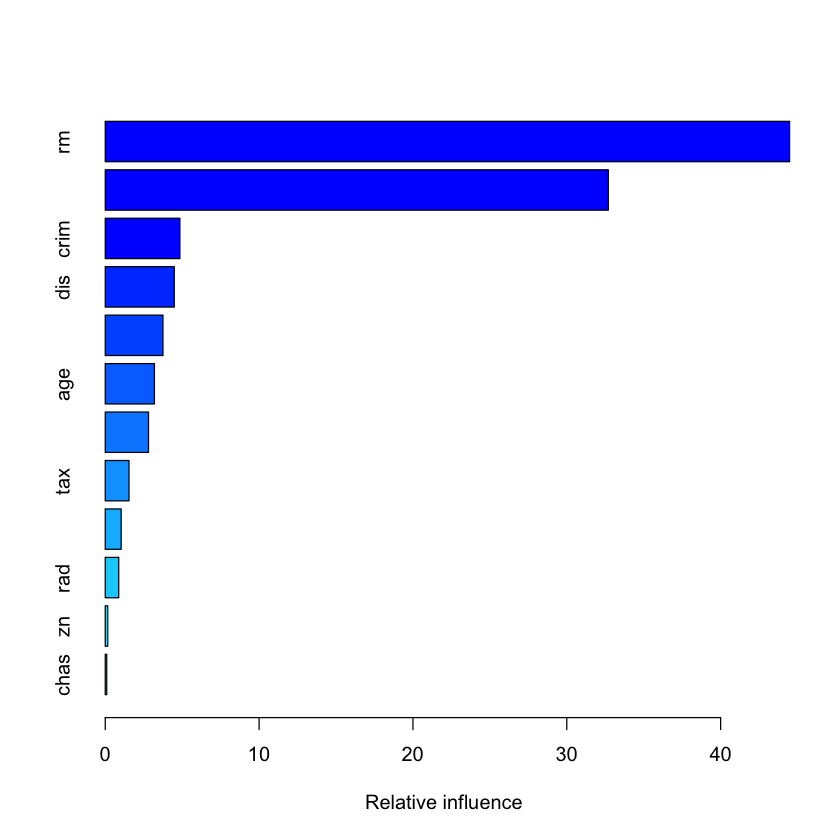

In [32]:
summary(boost.boston)

We see that `lstat` and `rm` are by far the most important variables. We can also produce *partial dependence plots* for these two variables. These plots illustrate the marginal effect of the selected variables on the response after *integrating* out the other variables. In this case, as we might expect, median house prices are increasing with `rm` and decreasing with `lstat`.

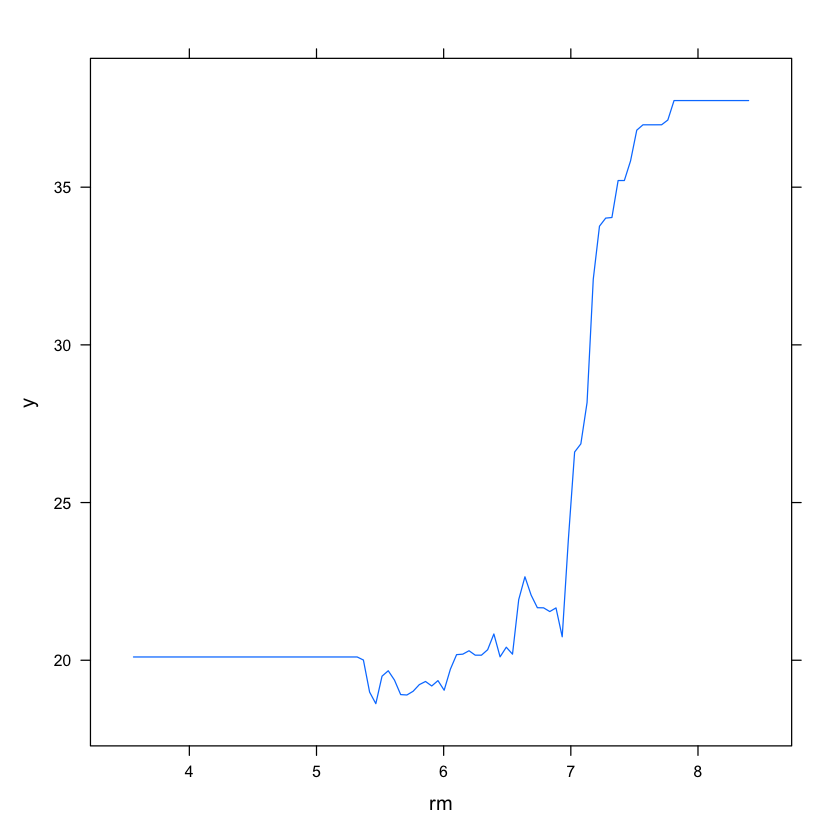

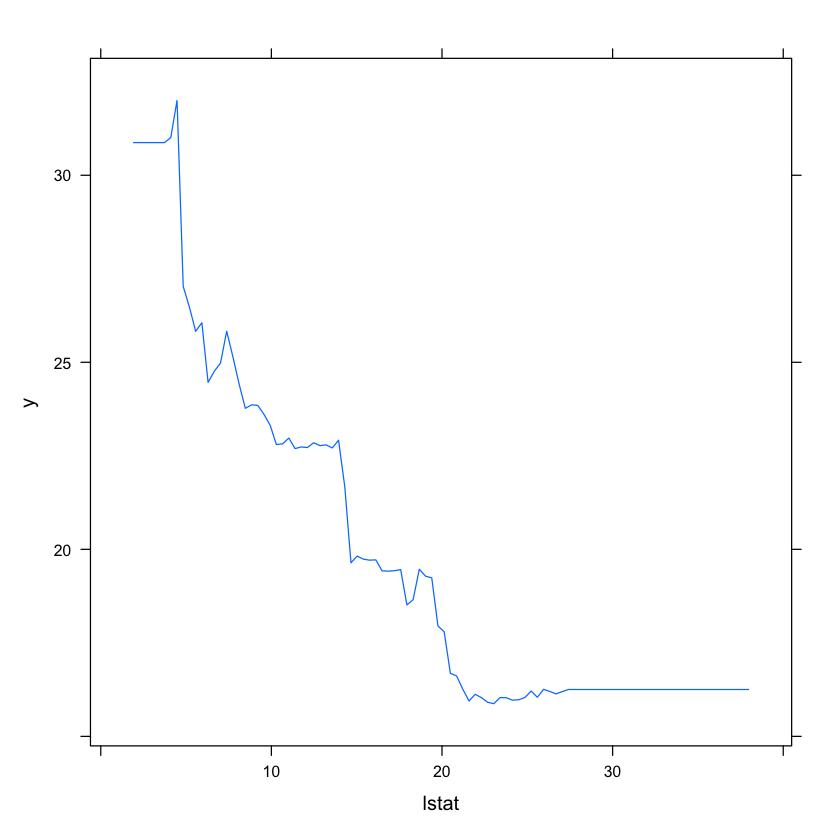

In [33]:
plot(boost.boston, i = "rm")
plot(boost.boston, i = "lstat")

We now use the boosted model to predict `medv` on the test set:

In [34]:
yhat.boost <- predict(boost.boston,
    newdata = Boston[-train, ], n.trees = 5000)
mean((yhat.boost - boston.test)^2)

[1] 18.39057

The test MSE obtained is $18.39$: this is superior to the test MSE of random forests and bagging. If we want to, we can perform boosting with a different value of the shrinkage parameter $\lambda$ in (8.10). The default value is $0.001$, but this is easily modified.
Here we take $\lambda=0.2$.

In [35]:
boost.boston <- gbm(medv ~ ., data = Boston[train, ],
    distribution = "gaussian", n.trees = 5000,
    interaction.depth = 4, shrinkage = 0.2, verbose = F)
yhat.boost <- predict(boost.boston,
    newdata = Boston[-train, ], n.trees = 5000)
mean((yhat.boost - boston.test)^2)

[1] 16.54778

In this case, using $\lambda=0.2$ leads to a lower test MSE than $\lambda=0.001$.




## Bayesian Additive Regression Trees


In this section  we use the `BART` package, and within it the `gbart()` function, to fit a Bayesian additive regression tree model to the `Boston` housing data set. The `gbart()` function  is
designed for quantitative outcome variables. For binary outcomes,   `lbart()`  and  `pbart()`  are available.

To run the `gbart()` function, we must first create matrices of predictors for the training and test data. We run BART with default settings.

In [37]:
#install.packages('BART')

In [38]:
library(BART)
x <- Boston[, 1:12]
y <- Boston[, "medv"]
xtrain <- x[train, ]
ytrain <- y[train]
xtest <- x[-train, ]
ytest <- y[-train]
set.seed(1)
bartfit <- gbart(xtrain, ytrain, x.test = xtest)

Loading required package: nlme

Loading required package: nnet

Loading required package: survival



*****Calling gbart: type=1
*****Data:
data:n,p,np: 253, 12, 253
y1,yn: 0.213439, -5.486561
x1,x[n*p]: 0.109590, 20.080000
xp1,xp[np*p]: 0.027310, 7.880000
*****Number of Trees: 200
*****Number of Cut Points: 100 ... 100
*****burn,nd,thin: 100,1000,1
*****Prior:beta,alpha,tau,nu,lambda,offset: 2,0.95,0.795495,3,3.71636,21.7866
*****sigma: 4.367914
*****w (weights): 1.000000 ... 1.000000
*****Dirichlet:sparse,theta,omega,a,b,rho,augment: 0,0,1,0.5,1,12,0
*****printevery: 100

MCMC
done 0 (out of 1100)
done 100 (out of 1100)
done 200 (out of 1100)
done 300 (out of 1100)
done 400 (out of 1100)
done 500 (out of 1100)
done 600 (out of 1100)
done 700 (out of 1100)
done 800 (out of 1100)
done 900 (out of 1100)
done 1000 (out of 1100)
time: 3s
trcnt,tecnt: 1000,1000


Next we compute the test error.

In [39]:
yhat.bart <- bartfit$yhat.test.mean
mean((ytest - yhat.bart)^2)

[1] 15.94718

On this data set, the test error of BART is lower than the test error of random forests and boosting.

Now we can check how many times each variable appeared in the collection of trees.

In [40]:
ord <- order(bartfit$varcount.mean, decreasing = T)
bartfit$varcount.mean[ord]

nox   lstat     tax     rad      rm   indus    chas ptratio     age      zn 
 22.952  21.329  21.250  20.781  19.890  19.825  19.051  18.976  18.274  15.952 
    dis    crim 
 14.457  11.007